In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import gzip

In [2]:
sns.set_theme(style = "whitegrid")
palette = sns.color_palette("crest_r")

In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [4]:
instruments = getDF('data/Musical_Instruments.json.gz')

In [5]:
instruments = instruments.sample(n = 20000, random_state = 42)

In [6]:
instruments = instruments.reset_index(drop = True)

In [7]:
instruments.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,2.0,NaN,True,"01 30, 2016",A4V3MZPLN3XUU,B005DBEAM0,NaN,G.L.,Two problems:\n\nIt just smells. I have to lea...,Still not tall enough.,1454112000,NaN
1,4.0,NaN,True,"07 14, 2017",A1VBE1QPSGE86B,B01EA91TI8,NaN,Nina M. Sundermeyer,This will be a gift. I have not used the produ...,This will be a gift. I have not used ...,1499990400,NaN
2,5.0,NaN,True,"06 17, 2015",A1HFCJ8R77PL2,B004XNK7AI,{'Color:': ' Black - SN-5'},CJ,I play many shows a month and this tuner keeps...,Very good,1434499200,NaN
3,3.0,NaN,True,"01 11, 2014",A1D9FXN98XXFR9,B001XJBWXG,{'Style:': ' AW-2G Clip-On Guitar Tuner'},KsBadBoy59,This was a gift for christmas for my son that ...,Clip-on Chromatic Guitar Tuner,1389398400,NaN
4,4.0,NaN,True,"07 23, 2016",A2M2RYPLQKJX3R,B012TAWYHU,NaN,DA,Does the job.,Four Stars,1469232000,NaN


In [8]:
instruments.overall.value_counts()

5.0    12978
4.0     3144
1.0     1590
3.0     1446
2.0      842
Name: overall, dtype: int64

<AxesSubplot: xlabel='overall', ylabel='count'>

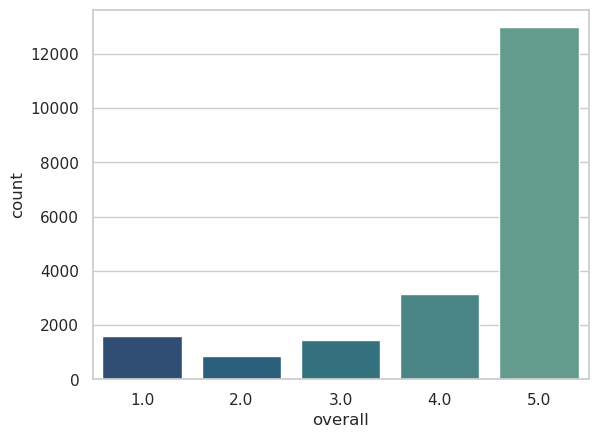

In [9]:
sns.countplot(data = instruments, x = 'overall', palette = palette)

In [10]:
instruments.isna().sum()/len(instruments)

overall           0.00000
vote              0.83965
verified          0.00000
reviewTime        0.00000
reviewerID        0.00000
asin              0.00000
style             0.55770
reviewerName      0.00005
reviewText        0.00025
summary           0.00050
unixReviewTime    0.00000
image             0.97860
dtype: float64

In [11]:
# Selecting relevant features
instruments = instruments[["overall", "verified", "reviewText", "summary"]]

In [12]:
# Dropping rows with no reviews
instruments = instruments.dropna(subset=["reviewText", "summary"])

In [13]:
instruments.isna().sum()

overall       0
verified      0
reviewText    0
summary       0
dtype: int64

In [14]:
instruments["reviewLength"] = instruments["reviewText"].apply(len)

/tmp/ipykernel_1566/1211419890.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = instruments, x = 'reviewLength', palette = palette)


<AxesSubplot: xlabel='reviewLength', ylabel='Count'>

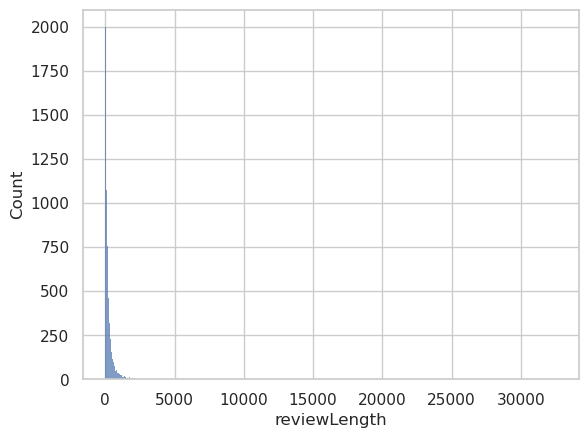

In [15]:
sns.histplot(data = instruments, x = 'reviewLength', palette = palette)

In [16]:
print(instruments.reviewLength.sort_values(ascending = False))

13926    32551
16225    12645
18606    11353
14926    10545
11511     8773
         ...  
19185        1
18821        1
17691        1
17905        1
1496         1
Name: reviewLength, Length: 19986, dtype: int64


In [17]:
instruments["logLength"] = instruments['reviewLength'].apply(np.log)

/tmp/ipykernel_1566/2977088613.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = instruments, x = 'logLength', palette = palette)


<AxesSubplot: xlabel='logLength', ylabel='Count'>

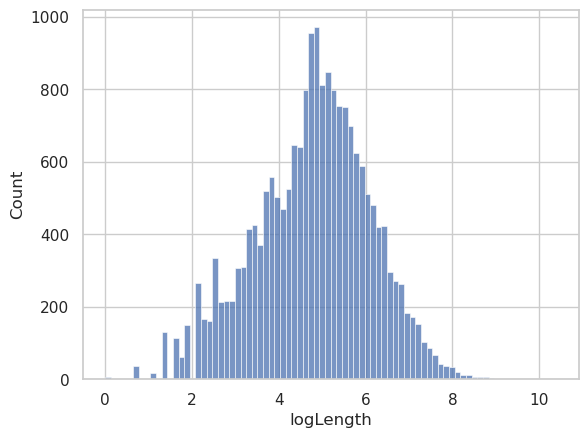

In [18]:
sns.histplot(data = instruments, x = 'logLength', palette = palette)

<AxesSubplot: xlabel='verified', ylabel='count'>

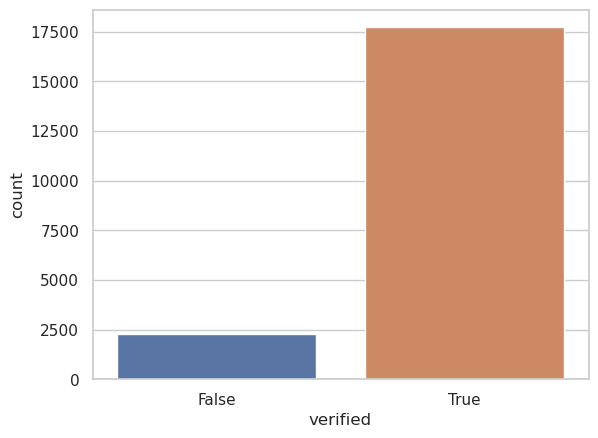

In [21]:
sns.countplot(data = instruments, x = 'verified')

### 1. Baseline Models

**Regression Model using Binary Feature Representation**

In [ ]:
#!pip install gensim
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [23]:
import spacy
import en_core_web_sm
from gensim.models import Word2Vec
nlp_processor = en_core_web_sm.load()
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
# To remove stopwords:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Defining Preprocessing function
def pre_processing_by_spacy(doc, lemma = True, need_sent = False):
    doc_class = nlp_processor(doc)
    tokens = []
    # step 1: get sentences
    for sent in doc_class.sents:
        # step 2: get tokens
        # step 3 (optional): lemma
        if lemma:
            words = [token.lemma_ for token in sent if not token.is_punct and not token.is_space]
        else:
            words = [token.text for token in sent if not token.is_punct and not token.is_space]
        if need_sent:
            tokens.append(words)
        else:
            tokens += words
            
    return [w.lower() for w in tokens if w.lower() not in stop]

In [26]:
instruments.reviewText[0:10].apply(pre_processing_by_spacy)

/tmp/ipykernel_12485/871273074.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  instruments.reviewText[0:10].apply(pre_processing_by_spacy)


0    [two, problem, smell, leave, garage, 2, week, ...
1    [gift, use, product, look, high, quality, make...
2    [play, many, show, month, tuner, keep, bass, s...
3    [gift, christmas, son, ask, far, hear, ir, wor...
4                                                [job]
5                                               [love]
6    [stable, secure, imagine, use, example, exerci...
7      [great, product, got, time, work, well, expect]
8    [totally, worth, extra, money, sturdy, well, m...
9    [case, great, short, indicate, website, hence,...
Name: reviewText, dtype: object

**Building Vocabulary**

We first define a dictionary (DF) with the total frequency of each word in the corpse.

In [30]:
y = instruments.overall
feat = instruments[["verified", "reviewText", 'summary', "logLength"]]

In [32]:
feat = pd.get_dummies(feat, columns = ['verified'], drop_first = True)

In [33]:
# Split data into train, test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feat, y, random_state=42, test_size=0.2, shuffle=True)

print(len(X_train), len(X_test))

15988 3998


In [35]:
from collections import defaultdict
from tqdm import tqdm

DF = defaultdict(float)
for doc in tqdm(X_train.reviewText):
    tokens = pre_processing_by_spacy(doc)
    for token in set(tokens):
        DF[token] += 1

100%|██████████| 15988/15988 [02:16<00:00, 117.40it/s]


In [36]:
from math import log
IDF, vocab = dict(), dict()
for token in DF:
    if DF[token] < 100:
        # this becomes an unk
        pass
    else:
        vocab[token] = len(vocab)
        IDF[token] = log(1 + len(X_train.reviewText) / DF[token])
print(len(DF), len(vocab))

18627 633


In [37]:
len(X_train.reviewText)

15988

We create the term "UNK" in our vocabulary, to group uncommon, rare, words.

In [39]:
IDF['<UNK>'] = 1
vocab['<UNK>'] = len(vocab)

In [40]:
print(vocab)

{'beginner': 0, 'install': 1, 'easy': 2, 'great': 3, 'mount': 4, 'case': 5, 'seem': 6, 'device': 7, 'take': 8, 'work': 9, 'ok': 10, 'actually': 11, 'produce': 12, 'plug': 13, 'quality': 14, 'music': 15, 'student': 16, 'use': 17, 'like': 18, 'get': 19, 'well': 20, 'capo': 21, 'idea': 22, 'guitar': 23, 'play': 24, 'way': 25, 'also': 26, 'nice': 27, 'since': 28, 'one': 29, 'song': 30, 'find': 31, 'material': 32, 'tune': 33, 'awesome': 34, 'without': 35, 'tight': 36, 'make': 37, 'heavy': 38, 'size': 39, 'product': 40, 'look': 41, 'neck': 42, 'player': 43, 'however': 44, 'electric': 45, 'wrong': 46, 'fret': 47, 'return': 48, 'even': 49, 'might': 50, 'nicely': 51, 'finish': 52, 'appear': 53, 'practice': 54, 'close': 55, 'adapter': 56, 'disappointed': 57, 'ear': 58, 'headphone': 59, 'another': 60, 'usb': 61, 'buy': 62, 'could': 63, 'perfectly': 64, 'soon': 65, 'start': 66, 'nothing': 67, 'setup': 68, 'need': 69, 'midi': 70, 'simple': 71, 'value': 72, 'show': 73, 'price': 74, 'tone': 75, 'bass

We define a function to create binary features:

In [41]:
def binary_feature_extractor(doc, vocab):
    tokens = pre_processing_by_spacy(doc)
    for i, token in enumerate(tokens):
        if token not in vocab:
            tokens[i] = '<UNK>'
    x = [0] * len(vocab)
    for token in set(tokens):
        token_id = vocab[token]
        x[token_id] = 1 # this will be a dense matrix
    return x

In [42]:
X_bin = []
for doc in tqdm(X_train.reviewText):
    X_bin.append(binary_feature_extractor(doc, vocab))

100%|██████████| 15988/15988 [02:01<00:00, 132.13it/s]


In [43]:
X_safe = X_bin.copy()

In [44]:
X_safe = sm.add_constant(X_safe)

In [45]:
X_safe.shape

(15988, 635)

In [46]:
X_safe = np.column_stack((X_safe, X_train.logLength, X_train.verified_True))

In [47]:
import scipy.sparse as sparse
sparse_X = sparse.csr_matrix(X_safe)

In [56]:
y_bin = y_train.values

In [57]:
from sklearn.linear_model import Ridge

In [60]:
lr_bin = Ridge()
lr_bin = lr_bin.fit(sparse_X, y_bin)

In [64]:
print(f"R-squared: {lr_bin.score(sparse_X, y_bin):.3f}")

R-squared: 0.408


**Model Evaluation:**

In [65]:
from sklearn.metrics import mean_squared_error

In [66]:
X_bin_test = []
for doc in tqdm(X_test.reviewText):
    X_bin_test.append(binary_feature_extractor(doc, vocab))

100%|██████████| 3998/3998 [00:31<00:00, 126.97it/s]


In [67]:
X_bin_test = sm.add_constant(X_bin_test)

In [68]:
X_bin_test = np.column_stack((X_bin_test, X_test.logLength, X_test.verified_True))

In [73]:
y_pred_train = lr_bin.predict(sparse_X)
y_pred = lr_bin.predict(X_bin_test)

In [71]:
from sklearn.metrics import mean_squared_error

In [76]:
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

Train RMSE: 0.954
Test RMSE: 1.003


#### 2. TF-IDF Feature Representation

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=True,
                        preprocessor=None,  # applied preprocessor in Data Cleaning
                        tokenizer=pre_processing_by_spacy,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

X_tfidf = tfidf.fit_transform(X_train.reviewText)

print('bag-of-words features ready!')

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


bag-of-words features ready!


In [78]:
vocab_train = tfidf.vocabulary_
len(vocab_train)

18170

In [79]:
lr_tfidf = Ridge()
lr_tfidf.fit(X_tfidf, y_train)

Ridge()

In [80]:
tfidf_test = TfidfVectorizer(strip_accents=None,
                        lowercase=True,
                        preprocessor=None,  # applied preprocessor in Data Cleaning
                        tokenizer=pre_processing_by_spacy,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True,
                        vocabulary = vocab_train)

In [81]:
# y_test = y_test.values
X_test = tfidf_test.fit_transform(X_test.reviewText)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [82]:
y_pred_train = lr_tfidf.predict(X_tfidf)
y_pred = lr_tfidf.predict(X_test)

In [85]:
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

Train RMSE: 0.725
Test RMSE: 0.933
